In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from math import sqrt

from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)

import seaborn as sns

In [2]:
test_file = '../data/cleaned_test.csv'
train_file = '../data/cleaned_train.csv'
spray_file = '../data/spray.csv'
weather_file = '../data/station_1_weather.csv'


train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
spray_df = pd.read_csv(spray_file)
weather_df = pd.read_csv(weather_file)

In [3]:
# Convert all Dates to DatetimeIndex first for merging by dates
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

In [4]:
# Merge train_df  and weather_df
train_weather = train_df.merge(weather_df, on='Date')
test_weather = test_df.merge(weather_df, on='Date')

In [5]:
train_weather.columns

Index(['Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'month_x', 'year_x', 'week_x',
       'YearWeek_x', 'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'NumMosquitos_cluster', 'trap_cluster',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'month_y', 'year_y', 'week_y', 'YearWeek_y', 'rh', 'daily_Tavg_lag_1',
       'daily_Tavg_lag_2', 'daily_Tavg_lag_3', 'daily_Tavg_lag_4',
       'daily_Tavg_lag_5', 'daily_rh_lag_1', 'daily_rh_lag_2',
       'daily_rh_lag_3', 'daily_rh_lag_4', 'daily_rh_lag_5',
       'weekly_Tavg_lag_1', 'weekly_

In [6]:
# Classify weather conditions from 3 weeks ago 
train_weather['superHot_superDry'] = np.where((train_weather['weekly_Tavg_lag_2']>=70) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
train_weather['Hot_Dry'] = np.where((train_weather['weekly_Tavg_lag_2']>65) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
train_weather['Hot_Wet'] = np.where((train_weather['weekly_Tavg_lag_2']>65) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)
train_weather['Cool_Dry'] = np.where((train_weather['weekly_Tavg_lag_2']<=65) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
train_weather['Cool_Wet'] = np.where((train_weather['weekly_Tavg_lag_2']<=65) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)


# Do the same for test set
test_weather['superHot_superDry'] = np.where((test_weather['weekly_Tavg_lag_2']>=70) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
test_weather['Hot_Dry'] = np.where((test_weather['weekly_Tavg_lag_2']>65) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
test_weather['Hot_Wet'] = np.where((test_weather['weekly_Tavg_lag_2']>65) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)
test_weather['Cool_Dry'] = np.where((test_weather['weekly_Tavg_lag_2']<=65) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
test_weather['Cool_Wet'] = np.where((test_weather['weekly_Tavg_lag_2']<=65) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)



In [7]:
# train_weather['superHot_superDry_2'] = np.where((train_weather['weekly_Tavg_lag_2']>=70) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
# train_weather['Hot_Dry_2'] = np.where((train_weather['weekly_Tavg_lag_2']>65) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
# train_weather['Hot_Wet_2'] = np.where((train_weather['weekly_Tavg_lag_2']>65) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)
# train_weather['Cool_Dry_2'] = np.where((train_weather['weekly_Tavg_lag_2']<=65) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
# train_weather['Cool_Wet_2'] = np.where((train_weather['weekly_Tavg_lag_2']<=65) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)


# test_weather['superHot_superDry_2'] = np.where((test_weather['weekly_Tavg_lag_2']>=70) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
# test_weather['Hot_Dry_2'] = np.where((test_weather['weekly_Tavg_lag_2']>65) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
# test_weather['Hot_Wet_2'] = np.where((test_weather['weekly_Tavg_lag_2']>65) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)
# test_weather['Cool_Dry_2'] = np.where((test_weather['weekly_Tavg_lag_2']<=65) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
# test_weather['Cool_Wet_2'] = np.where((test_weather['weekly_Tavg_lag_2']<=65) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)

In [8]:
# train_weather['superHot_superDry_1'] = np.where((train_weather['weekly_Tavg_lag_1']>=70) & (train_weather['weekly_rh_lag_1']<60), 1, 0)
# train_weather['Hot_Dry_1'] = np.where((train_weather['weekly_Tavg_lag_1']>65) & (train_weather['weekly_rh_lag_1']<60), 1, 0)
# train_weather['Hot_Wet_1'] = np.where((train_weather['weekly_Tavg_lag_1']>65) & (train_weather['weekly_rh_lag_1']>=60), 1, 0)
# train_weather['Cool_Dry_1'] = np.where((train_weather['weekly_Tavg_lag_1']<=65) & (train_weather['weekly_rh_lag_1']<60), 1, 0)
# train_weather['Cool_Wet_1'] = np.where((train_weather['weekly_Tavg_lag_1']<=65) & (train_weather['weekly_rh_lag_1']>=60), 1, 0)


# test_weather['superHot_superDry_1'] = np.where((test_weather['weekly_Tavg_lag_1']>=70) & (test_weather['weekly_rh_lag_1']<60), 1, 0)
# test_weather['Hot_Dry_1'] = np.where((test_weather['weekly_Tavg_lag_1']>65) & (test_weather['weekly_rh_lag_1']<60), 1, 0)
# test_weather['Hot_Wet_1'] = np.where((test_weather['weekly_Tavg_lag_1']>65) & (test_weather['weekly_rh_lag_1']>=60), 1, 0)
# test_weather['Cool_Dry_1'] = np.where((test_weather['weekly_Tavg_lag_1']<=65) & (test_weather['weekly_rh_lag_1']<60), 1, 0)
# test_weather['Cool_Wet_1'] = np.where((test_weather['weekly_Tavg_lag_1']<=65) & (test_weather['weekly_rh_lag_1']>=60), 1, 0)

In [9]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10413 entries, 2007-05-29 to 2013-09-26
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Address                         10413 non-null  object 
 1   Species                         10413 non-null  object 
 2   Block                           10413 non-null  int64  
 3   Street                          10413 non-null  object 
 4   Trap                            10413 non-null  object 
 5   AddressNumberAndStreet          10413 non-null  object 
 6   Latitude                        10413 non-null  float64
 7   Longitude                       10413 non-null  float64
 8   AddressAccuracy                 10413 non-null  int64  
 9   NumMosquitos                    10413 non-null  int64  
 10  WnvPresent                      10413 non-null  int64  
 11  month_x                         10413 non-null  int64  
 12  year_x         

In [10]:
train_weather.columns

Index(['Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'month_x', 'year_x', 'week_x',
       'YearWeek_x', 'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'NumMosquitos_cluster', 'trap_cluster',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'month_y', 'year_y', 'week_y', 'YearWeek_y', 'rh', 'daily_Tavg_lag_1',
       'daily_Tavg_lag_2', 'daily_Tavg_lag_3', 'daily_Tavg_lag_4',
       'daily_Tavg_lag_5', 'daily_rh_lag_1', 'daily_rh_lag_2',
       'daily_rh_lag_3', 'daily_rh_lag_4', 'daily_rh_lag_5',
       'weekly_Tavg_lag_1', 'weekly_

In [11]:
# Create new df for the selected X features for modeling

X_features = [
            'Latitude', 'Longitude',
            'month_x',             # duplicate 'month' column when merging train/test with weather
            #'Trap',
            #'AddressNumberAndStreet',
            'Species_CULEX PIPIENS',
            'Species_CULEX PIPIENS/RESTUANS',
            'Species_CULEX RESTUANS',
            #'Species_CULEX SALINARIUS', 
            #'Species_CULEX TARSALIS',
            #'Species_CULEX TERRITANS',
            #'Species_CULEX ERRATICUS', 
            'NumMosquitos_cluster', 
            'trap_cluster', 
            #'WetBulb', 
            #'Heat', 
            #'Cool', 
            #'Sunrise', 
            #'Sunset',
#             'PrecipTotal', 
            #'StnPressure', 
            #'SeaLevel', 
            #'ResultSpeed', 
            #'ResultDir',
            #'AvgSpeed',
            'Tmin',
            'rh',
#             'daily_Tavg_lag_1', 
#             'daily_Tavg_lag_2', 
            # 'daily_Tavg_lag_3',
#             'daily_Tavg_lag_4',
#             'daily_Tavg_lag_5',
#             'daily_rh_lag_1', 
#             'daily_rh_lag_2', 
            # 'daily_rh_lag_3',
            # 'daily_rh_lag_4', 
#             'daily_rh_lag_5',
#             'weekly_Tavg_lag_1',
            # 'weekly_Tavg_lag_2',
            # 'weekly_Tavg_lag_3',
            # 'weekly_Tavg_lag_4',
#             'weekly_Tavg_lag_5',
            # 'weekly_rh_lag_1', 
            # 'weekly_rh_lag_2',
            # 'weekly_rh_lag_3',
            # 'weekly_rh_lag_4',
#             'weekly_rh_lag_5',
            'superHot_superDry', 
#             'Hot_Dry', 
            'Hot_Wet', 
            'Cool_Dry', 
            'Cool_Wet',
            #'superHot_superDry_2', 'Hot_Dry_2', 'Hot_Wet_2', 'Cool_Dry_2', 'Cool_Wet_2', 
            #'superHot_superDry_1', 'Hot_Dry_1', 'Hot_Wet_1', 'Cool_Dry_1', 'Cool_Wet_1',
#             'weekly_precip_lag_2', 
            # 'weekly_precip_lag_3', 
            # 'weekly_precip_lag_4',
            # 'weekly_precip_lag_5',
#             'weekly_StnPressure_lag_1',
            'weekly_StnPressure_lag_2',
            # 'weekly_StnPressure_lag_3', 
            # 'weekly_StnPressure_lag_4',
            # 'weekly_StnPressure_lag_5', 
            # 'weekly_SeaLevel_lag_1',
            'weekly_SeaLevel_lag_2',
#             'weekly_SeaLevel_lag_3',
#             'weekly_SeaLevel_lag_4', 
#             'weekly_SeaLevel_lag_5'

             ]

# 

selected_X_train = train_weather[X_features].copy()


selected_X_test = test_weather[X_features].copy()




# Set y target for binary classification
y = train_weather['WnvPresent']


selected_X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10413 entries, 2007-05-29 to 2013-09-26
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        10413 non-null  float64
 1   Longitude                       10413 non-null  float64
 2   month_x                         10413 non-null  int64  
 3   Species_CULEX PIPIENS           10413 non-null  float64
 4   Species_CULEX PIPIENS/RESTUANS  10413 non-null  float64
 5   Species_CULEX RESTUANS          10413 non-null  float64
 6   NumMosquitos_cluster            10413 non-null  int64  
 7   trap_cluster                    10413 non-null  int64  
 8   Tmin                            10413 non-null  int64  
 9   rh                              10413 non-null  float64
 10  superHot_superDry               10413 non-null  int32  
 11  Hot_Wet                         10413 non-null  int32  
 12  Cool_Dry       

In [12]:
selected_X_train.isnull().sum()

Latitude                          0
Longitude                         0
month_x                           0
Species_CULEX PIPIENS             0
Species_CULEX PIPIENS/RESTUANS    0
Species_CULEX RESTUANS            0
NumMosquitos_cluster              0
trap_cluster                      0
Tmin                              0
rh                                0
superHot_superDry                 0
Hot_Wet                           0
Cool_Dry                          0
Cool_Wet                          0
weekly_StnPressure_lag_2          0
weekly_SeaLevel_lag_2             0
dtype: int64

In [13]:
def coll_checker(df, tol): #remember to remove target!
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    return [column for column in upper_tri.columns if any(upper_tri[column] > tol)]

In [14]:
# Check for multicollinearity among the selected X features
coll_checker(selected_X_train, 0.75)

['weekly_SeaLevel_lag_2']

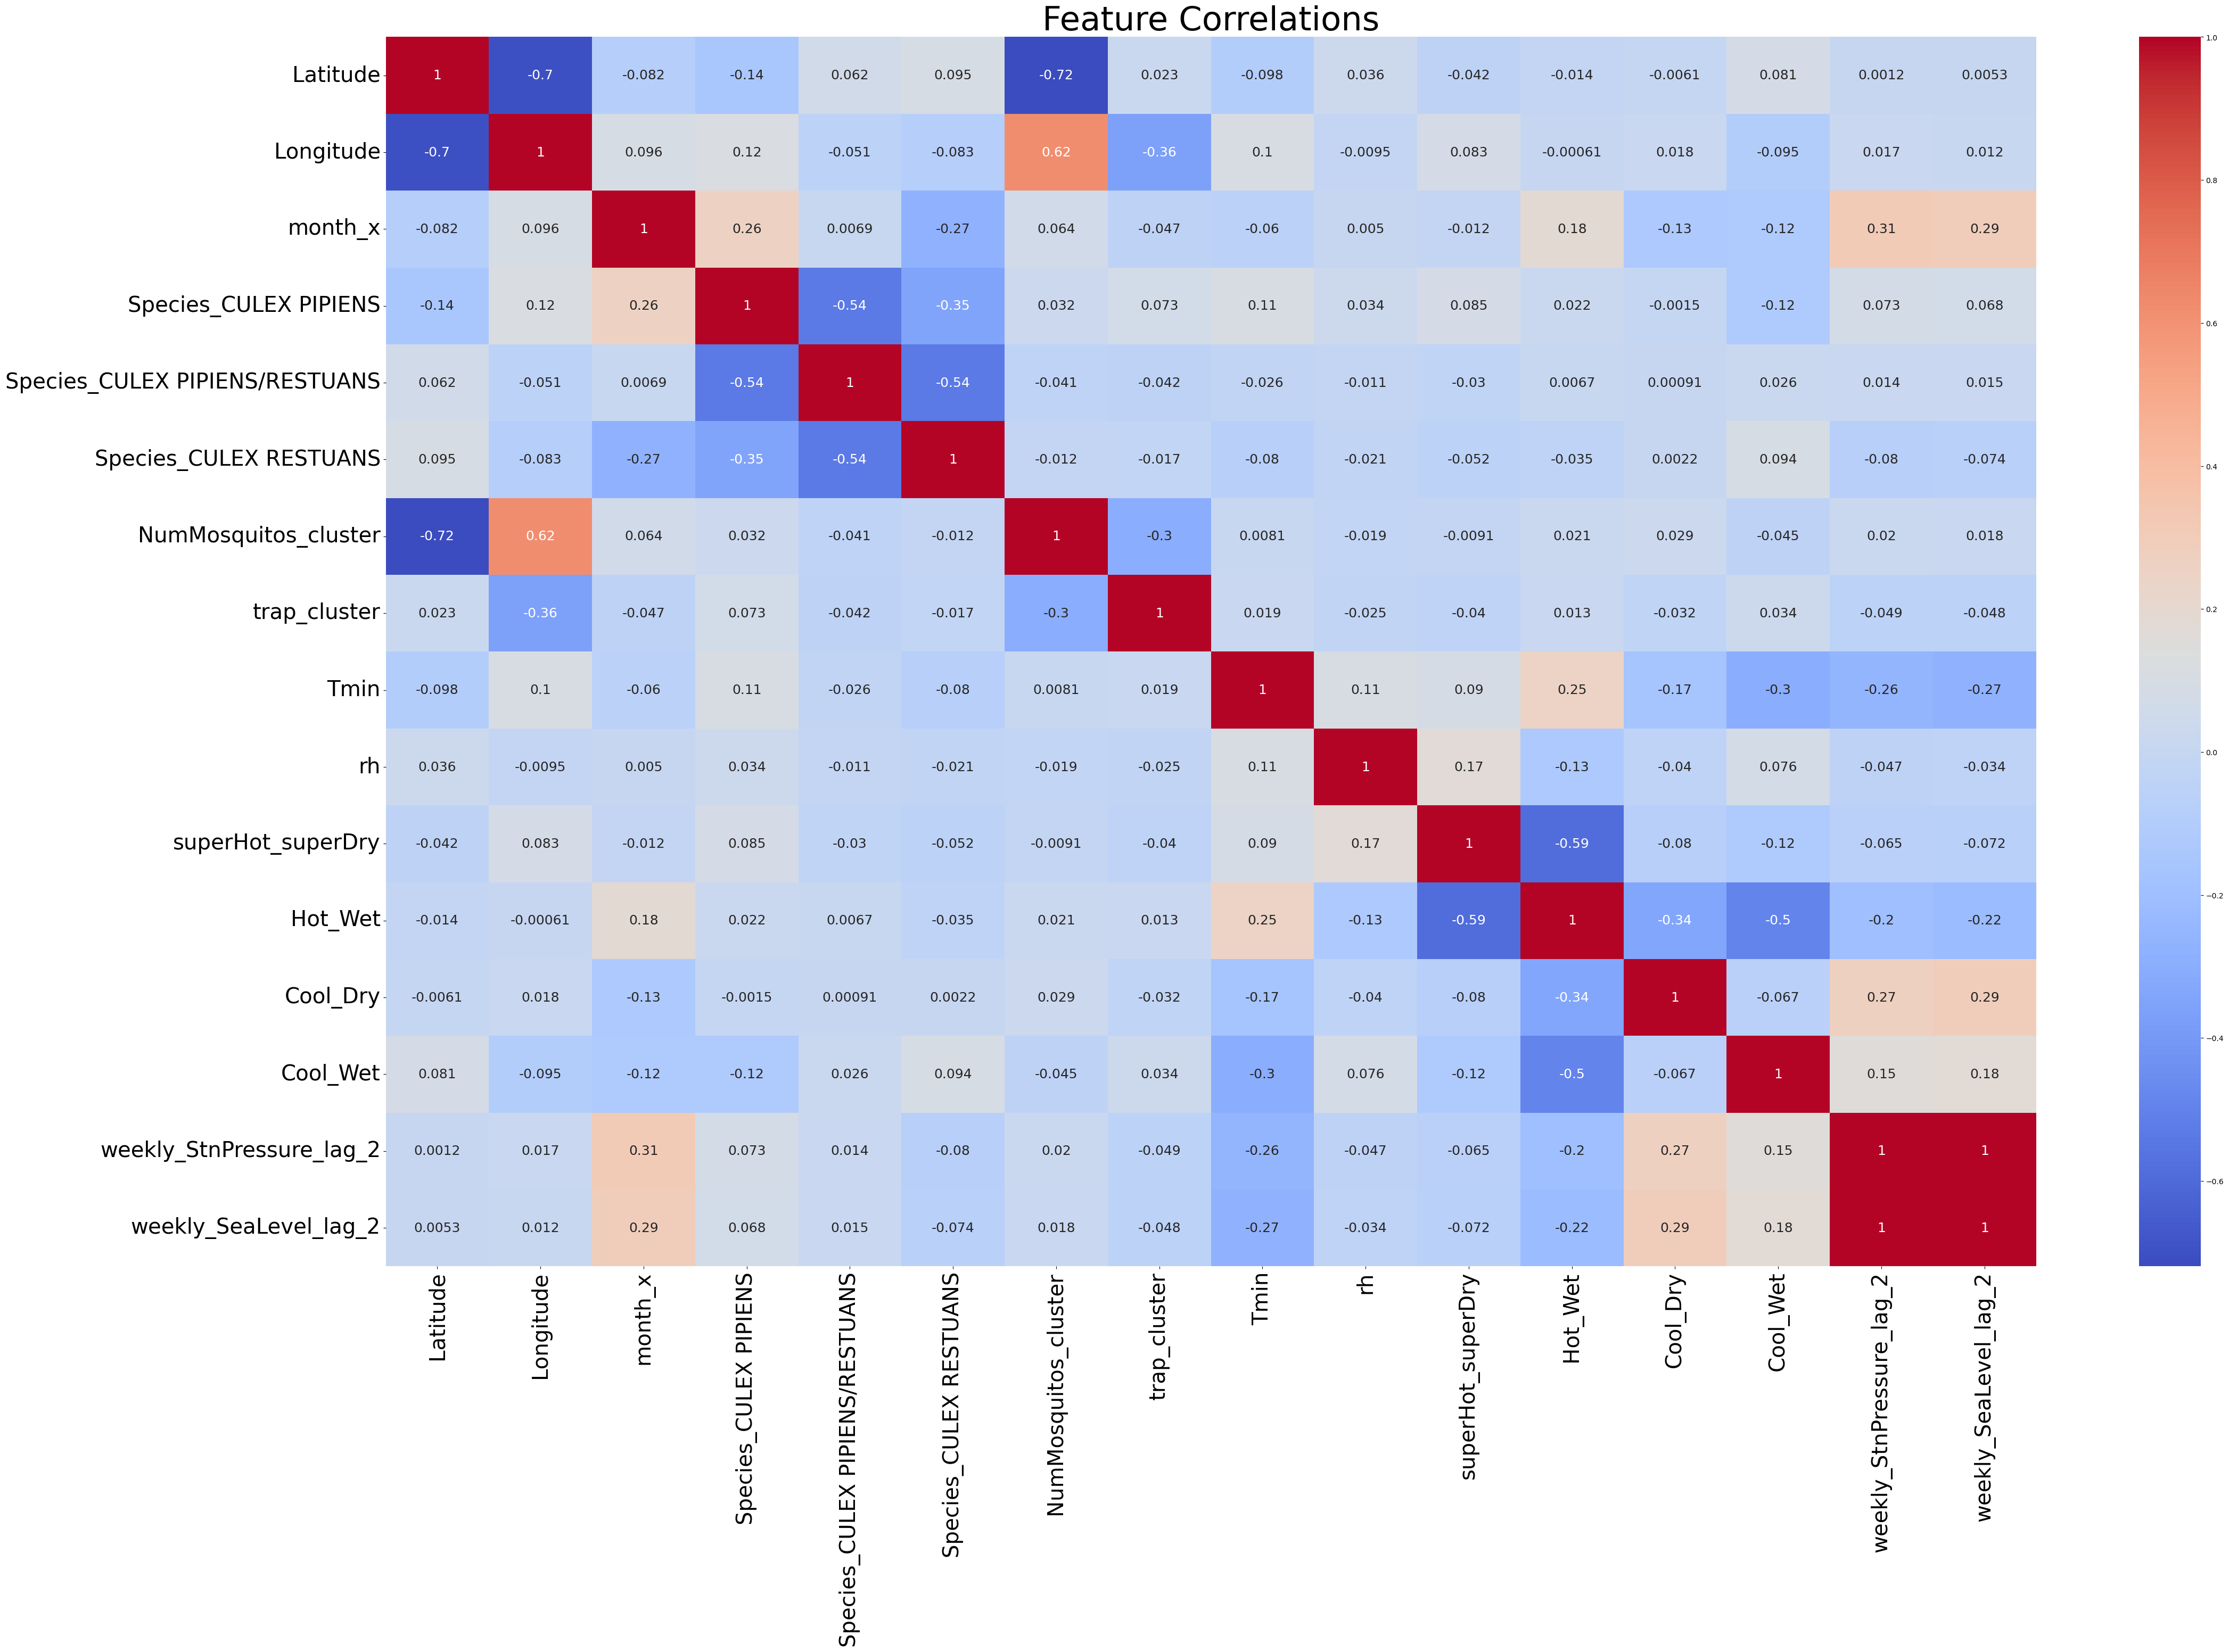

In [15]:
# Visually seeing that there is No multicollinearity among all the selected X features!
plt.figure(figsize=(50,30))
sns.heatmap(selected_X_train.corr(), cmap='coolwarm', annot=True, annot_kws={"fontsize": 18})
plt.tick_params(axis='both', labelsize=29)
plt.title("Feature Correlations", fontsize=45);

In [16]:
# Creating Polynomial Features

poly = PolynomialFeatures(include_bias=False, interaction_only=False, degree=2)
poly_X_train = poly.fit_transform(selected_X_train)
poly_X_test = poly.transform(selected_X_test)

In [17]:
# Standardscale all X features first

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)

ss = StandardScaler()
train_X_scaled = ss.fit_transform(train_X)    
val_X_scaled = ss.transform(val_X)          
X_test_scaled = ss.transform(selected_X_test)    # use selected_X_test / poly_X_test

# Create balanced dataset by SMOTE oversampling first
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(train_X_scaled, train_y)

print(ysm_train.value_counts())
print(Xsm_train.shape)


# Training dataset is now 50:50 between the two classes.

0    7396
1    7396
Name: WnvPresent, dtype: int64
(14792, 16)


In [18]:
# LogisticRegression model

lr = LogisticRegression(C=0.000001)
lr.fit(Xsm_train, ysm_train)


print(f'Training ROC score: {roc_auc_score(ysm_train, lr.predict_proba(Xsm_train)[:,1])}')
print(f'Validation ROC score: {roc_auc_score(val_y, lr.predict_proba(val_X)[:,1])}')

print(f'Training ROC score: {roc_auc_score(train_y, lr.predict_proba(train_X)[:,1])}')
print(f'Validation ROC score: {roc_auc_score(val_y, lr.predict_proba(val_X)[:,1])}')


Training ROC score: 0.7575852981790985
Validation ROC score: 0.6810433489662306
Training ROC score: 0.6589785133512389
Validation ROC score: 0.6810433489662306


C:\Users\samue\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [19]:
# kNN model

knn = KNeighborsClassifier(n_neighbors=300)
knn.fit(Xsm_train, ysm_train)

print(f'Training ROC score: {roc_auc_score(ysm_train, knn.predict_proba(Xsm_train)[:,1])}')
print(f'Validation ROC score: {roc_auc_score(val_y, knn.predict_proba(val_X)[:,1])}')


# print(f'Training ROC score: {roc_auc_score(train_y, knn.predict_proba(train_X)[:,1])}')
# print(f'Validation ROC score: {roc_auc_score(val_y, knn.predict_proba(val_X)[:,1])}')

Training ROC score: 0.811207542132461


C:\Users\samue\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation ROC score: 0.4678012271236645


In [25]:
# RandomForestClassifier model

rf = RandomForestClassifier(random_state=42)
rf.fit(Xsm_train, ysm_train)


print(f'Training ROC score: {roc_auc_score(ysm_train, rf.predict_proba(Xsm_train)[:,1])}')
print(f'Validation ROC score: {roc_auc_score(val_y, rf.predict_proba(val_X)[:,1])}')


# print(f'Training ROC score: {roc_auc_score(train_y, rf.predict_proba(train_X)[:,1])}')
# print(f'Validation ROC score: {roc_auc_score(val_y, rf.predict_proba(val_X)[:,1])}')

Training ROC score: 0.9987598174038207


C:\Users\samue\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Validation ROC score: 0.5889444268133573


In [21]:
# XGBoost model

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.15, n_jobs=-1, random_state=42)
xgb.fit(Xsm_train, ysm_train)

print(f'Training ROC score: {roc_auc_score(ysm_train,xgb.predict_proba(Xsm_train)[:,1])}')
print(f'Validation ROC score: {roc_auc_score(val_y, xgb.predict_proba(val_X)[:,1])}')

# print(f'Training ROC score: {roc_auc_score(train_y, xgb.predict_proba(train_X)[:,1])}')
# print(f'Validation ROC score: {roc_auc_score(val_y, sgb.predict_proba(val_X)[:,1])}')

Training ROC score: 0.9991417495490378
Validation ROC score: 0.43960618028374293


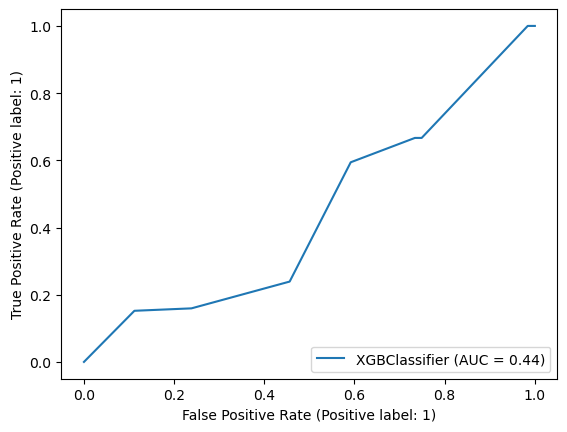

In [22]:
rfc_display = RocCurveDisplay.from_estimator(xgb, val_X, val_y)

In [23]:
# Kaggle Submission

original_test_df = pd.read_csv('../data/cleaned_test.csv')

y_preds = lr.predict(X_test_scaled)     # Change fitted_model here will do

# Create csv for Kaggle Submission
submission_csv = pd.DataFrame(columns=['Id', 'WnvPresent'])
submission_csv['Id'] = original_test_df['Id']
submission_csv['WnvPresent'] = y_preds

submission_csv.to_csv('../data/kaggle_submission.csv', index=False)